In [1]:
from data import Data
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import itertools
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
d = Data(first=600, x_transpose=(0, 3, 1, 2))
X_train,y_train = d.get_train()
X_cross, y_cross = d.get_dev()
X_test,y_test = d.get_test()

loaded 100
loaded 200
loaded 300
loaded 400
loaded 500
loaded 600
loaded 700
loaded 800
loaded 900
loaded 1000
loaded 1100
loaded 1200


In [3]:
y_train = y_train
print(X_train.shape)
print(y_train.shape)
print(X_cross.shape)
print(y_cross.shape)
print(X_test.shape)
print(y_test.shape)

(637, 3, 224, 224)
(637,)
(196, 3, 224, 224)
(196,)
(147, 3, 224, 224)
(147,)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.models as models

USE_GPU = True
if USE_GPU:
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor

In [5]:
def flatten(X):
    N = X.shape[0]
    return X.view(N,-1)

In [6]:
class Flatten(nn.Module):
    def forward(self, x): 
        return flatten(x)

In [7]:
class MyCustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        img = self.X[index]
        label = self.y[index]
        return (img, label)

    def __len__(self):
        return self.X.shape[0]

In [8]:
NUM_TRAIN = X_train.shape[0]
train_dataset = MyCustomDataset(X_train, y_train)
loader_train = DataLoader(train_dataset, batch_size=20,sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cross_dataset = MyCustomDataset(X_cross, y_cross)
loader_cross = DataLoader(cross_dataset, batch_size=20)

In [9]:
def check_accuracy(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            scores = model(Variable(x.float().type(dtypeFloat)))
            _, preds = scores.max(1)
            num_correct += (preds == Variable(y.long().type(dtypeLong))).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [10]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    print(img.shape)
    img = img.transpose(1,2,0)
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

In [11]:
print_every = 50
print_acc_every = 150
show_transformations = False

def train(m, optimizer, epochs=15):
    loss_arr = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            m.train()
            scores = m(Variable(x.float().type(dtypeFloat)))
            loss = F.cross_entropy(scores, Variable(y.long().type(dtypeLong)))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss))
                loss_arr += [loss.item()]
                if (t % print_acc_every == 0):
                    print ("train acc:")
                    check_accuracy(loader_train, m)
                    print ("cross acc:")
                    m.eval()
                    check_accuracy(loader_cross, m)
                    
                    # print transformations
                    if show_transformations:
                        x_ = x[5][None]
                        stn = next(m.modules())[0]
                        plt.subplot(1, 2, 1)
                        i = 50
                        imshow_noax(x_.data.numpy()[0], normalize=False)
                        plt.subplot(1, 2, 2)
                        stn_out = stn(Variable(x_.float().type(dtypeFloat))).data.numpy()[0]
                        imshow_noax(stn_out, normalize=False)
                        plt.show()
                    
    return loss_arr

In [12]:
attn_channel_1 = 96
attn_channel_2 = 128
attn_channel_3 = 256
n_class=2

class FeatureExtraction(nn.Module):
    def __init__(self):
        super(FeatureExtraction, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(3, attn_channel_1, 7, stride=1, padding=3), # 224 x 224 x 96
            nn.MaxPool2d(2, stride=2), # 112 x 112 x 96
            nn.ReLU(),
            nn.Conv2d(attn_channel_1, attn_channel_2, 5, stride=1, padding=2), # 112 x 112 x 128
            nn.MaxPool2d(2, stride=2), # 56 x 56 x 128
            nn.ReLU(),
            nn.Conv2d(attn_channel_2, attn_channel_3, 3, stride=1, padding=1), # 56 x 56 x 256
            nn.MaxPool2d(2, stride=2), # 28 x 28 x 256
            nn.ReLU(),
#             Flatten(),
#             nn.Linear(28*28*256, n_class),
        )       
        
    def forward(self, x):
        return self.model(x)

In [ ]:
#def AttentitiveConvLSTM_step(lots of shit)

In [14]:
filter_size=5
C, H, W = 256, 28, 28

class AttentiveConvLSTM(nn.Module):
    def __init__(self):
        super(AttentiveConvLSTM, self).__init__()
        
        self.Wi = torch.randn(filter_size, filter_size) 
        self.Wf = torch.randn(filter_size, filter_size)
        self.Wo = torch.randn(filter_size, filter_size)
        self.Wc = torch.randn(filter_size, filter_size)
        
        self.Ui = torch.randn(filter_size, filter_size)
        self.Uf = torch.randn(filter_size, filter_size)
        self.Uo = torch.randn(filter_size, filter_size)
        self.Uc = torch.randn(filter_size, filter_size)
        
        self.bi = torch.randn(H)
        self.bf = torch.randn(H)
        self.bo = torch.randn(H)
        self.bc = torch.randn(H)
        
        self.H0 = torch.randn(C, H, W)
        self.C0 = torch.randn(C, H, W)
        
        self.Att = torch.randn(C, H, W)
        
#         self.model = nn.Sequential(            
#             nn.Conv2d(3, attn_channel_1, 7, stride=1, padding=3), # 224 x 224 x 96
#             nn.MaxPool2d(2, stride=2), # 112 x 112 x 96
#             nn.ReLU(),
#             nn.Conv2d(attn_channel_1, attn_channel_2, 5, stride=1, padding=2), # 112 x 112 x 128
#             nn.MaxPool2d(2, stride=2), # 56 x 56 x 128
#             nn.ReLU(),
#             nn.Conv2d(attn_channel_2, attn_channel_3, 3, stride=1, padding=1), # 56 x 56 x 256
#             nn.MaxPool2d(2, stride=2), # 28 x 28 x 256
#             nn.ReLU(),
#             Flatten(),
#             nn.Linear(28*28*256, n_class),
        )       
        
    def forward(self, x):
        # put the forward pass here (iterating through the channels of X)
        # iteratively call AttentitiveConvLSTM_step
        # Return X', which is the features modified with the attention map
        return self.model(x)

SyntaxError: invalid syntax (<ipython-input-14-a497e18125a0>, line 27)

(256, 28, 28)


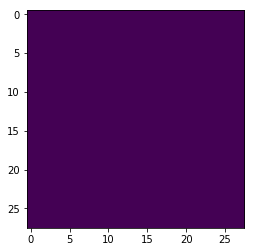

In [13]:
learning_rate = 2.2e-4
num_classes = 2

model = nn.Sequential(
    FeatureExtraction(),
    AttentiveConvLSTM(), # outputs attention map
)
if USE_GPU:
    model = model.cuda()
    
# image generation (to see feature map), and also the way to forward pass
for t, (x, y) in enumerate(loader_train):
    img = model(Variable(x.float().type(dtypeFloat)))
    img = img[0].data.cpu().numpy()
    print (img.shape)
    imgplot = plt.imshow(img[100])
    break
    
# optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# loss_arr = train(model, optimizer, 15)

# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
# plt.plot(loss_arr)
# plt.show()